# FOMO - Faster Objects, More Objects

## FOMO Common

#### Import modules

In [64]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.io import read_image
from torchvision.transforms import Resize
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

import pytorch_lightning as pl

from pytorch_lightning.loggers import MLFlowLogger

#### Constants

In [65]:
DATASET_DIR = Path("data")
IMAGE_RESOLUTION = 224
GRID_SCALE = 8
NUMBER_OF_CLASSES = 1

NUMBER_OF_EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

#### BoundingBoxToMask

In [66]:
class BoundingBoxToMask:
    """Convert YOLO bounding boxes to FOMO centroids"""

    def __init__(self, image_resolution: int, grid_scale: int, number_of_classes: int):
        self._image_resolution = image_resolution
        self._grid_scale = grid_scale
        self._number_of_classes = number_of_classes

    def __call__(self, label):
        grid_resolution = int(self._image_resolution / self._grid_scale)

        background_mask = torch.ones((grid_resolution, grid_resolution), dtype=float)

        masks = []
        for i in range(self._number_of_classes):
            class_mask = torch.zeros((grid_resolution, grid_resolution), dtype=float)
            bounding_boxes = label.readlines()
            for bounding_box in bounding_boxes:
                [c, x, y, _, _] = [
                    float(coords) for coords in bounding_box.split()
                ]  # get bounding box class, position and dimension
                if c == i:
                    x = int(x * grid_resolution)
                    y = int(y * grid_resolution)
                    class_mask[y, x] = 1.0
                    background_mask[y, x] = 0.0

            masks.append(class_mask)
        masks = [background_mask] + masks
        return torch.stack(masks)

#### Dataset

In [67]:
class VehicleDataset(Dataset):
    def __init__(
        self,
        dataset_dir: Path,
        subset: list[str],
        transform=None,
        target_transform=None,
    ):
        self._images = [
            dataset_dir / "images" / (element + ".jpg") for element in subset
        ]
        self._bounding_boxes = [
            dataset_dir / "labels" / (element + ".txt") for element in subset
        ]
        self._transform = transform
        self._target_transform = target_transform

    def __getitem__(self, idx: int):
        image_path = self._images[idx]
        image = read_image(str(image_path))
        image = self._transform(image.float())

        bounding_box_path = self._bounding_boxes[idx]
        bounding_box_file = open(bounding_box_path)
        mask = self._target_transform(bounding_box_file)

        return image, mask

    def __len__(self):
        return len(self._images)

#### DataModule

In [68]:
class VehicleDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dataset_dir: Path,
        input_resolution: int,
        grid_scale: int,
        batch_size: int,
    ):
        super().__init__()
        self._dataset_dir = dataset_dir
        self._input_resolution = input_resolution  # model input image resolution (assume input is squared shape)
        self._grid_scale = grid_scale  # number of pixels per cell on prediction grid (vertically and horizontally)
        self._batch_size = batch_size

        self._transform = Resize((input_resolution, input_resolution), antialias=True)
        self._target_transform = BoundingBoxToMask(input_resolution, grid_scale, 1)
        self._train_dataset = None
        self._val_dataset = None

    def setup(self, stage: str):
        data_names = sorted(
            [data_name for data_name in (self._dataset_dir / "images").iterdir()]
        )
        # TODO: Split in folders instead of here
        train_names, val_names = random_split(data_names, [0.85, 0.15])
        self._train_dataset = VehicleDataset(
            self._dataset_dir,
            [data_names[idx].stem for idx in train_names.indices],
            self._transform,
            self._target_transform,
        )
        self._val_dataset = VehicleDataset(
            self._dataset_dir,
            [data_names[idx].stem for idx in val_names.indices],
            self._transform,
            self._target_transform,
        )

    def train_dataloader(self):
        return DataLoader(self._train_dataset, batch_size=self._batch_size)

    def val_dataloader(self):
        return DataLoader(self._val_dataset, batch_size=self._batch_size)

#### FOMO network architecture

In [69]:
def fomo_net(weights: None, number_of_classes: int) -> nn.Module:
    """
    Constructs a FOMO net model with a specified number of classes.
    Input resolution is decreased by a factor of 8.
    """
    model = mobilenet_v2(weights=weights)

    # Remove layers after 1/8 reduction
    cut_inverted_residual = 7
    features = [
        nn.Identity() if i > cut_inverted_residual else model.features[i]
        for i, _ in enumerate(model.features)
    ]
    features[cut_inverted_residual].conv[1] = nn.Identity()
    features[cut_inverted_residual].conv[2] = nn.Identity()
    features[cut_inverted_residual].conv[3] = nn.Identity()
    model = nn.Sequential(*features)

    # Add classification layers
    number_of_classes_with_background = number_of_classes + 1
    model.classifier = nn.Sequential(
        nn.Conv2d(in_channels=192, out_channels=32, kernel_size=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=32,
            out_channels=number_of_classes_with_background,
            kernel_size=1,
            stride=1,
        ),
    )
    return model

#### LightningModule

In [70]:
class FomoModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self._network = fomo_net(
            weights=MobileNet_V2_Weights.DEFAULT,
            number_of_classes=NUMBER_OF_CLASSES,
        )
        self._loss_function = nn.BCEWithLogitsLoss()  # !!!

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self._network(inputs)

    def training_step(self, batch, batch_idx):
        image, mask = batch
        mask_pred = self(image)
        loss = self._loss_function(mask_pred, mask)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        image, mask = batch
        mask_pred = self(image)
        loss = self._loss_function(mask_pred, mask)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)

#### Funtion to postprocess the mask generated by FOMO

In [71]:
def postprocess_fomo_mask_prediction(
    mask_pred: torch.Tensor, threshold: float
) -> torch.Tensor:
    """
    Postprocesses FOMO mask prediction to squish output between [0:1] and remove multiple detections of the same object
    """
    mask_pred = torch.sigmoid(mask_pred)
    for single_mask_pred in mask_pred.unbind(0):
        for i, channel in enumerate(single_mask_pred.unbind(0)):
            channel = channel.numpy()
            binary_channel = np.where(channel > threshold, 1.0, 0.0).astype(np.int8)

            if i != 0:  # Skip the background mask
                number_of_blobs, blobs = cv2.connectedComponentsWithAlgorithm(binary_channel, connectivity=8, ltype=cv2.CV_32S, ccltype=cv2.CCL_WU)
                binary_channel.fill(0)
                for blob in range(1, number_of_blobs):
                    max_val = np.max(channel[blobs == blob])
                    binary_channel += np.where(channel == max_val, 1, 0)

            single_mask_pred[i] = torch.from_numpy(binary_channel)
    return mask_pred

In [72]:
# TODO: Remove when data is split in folders
vehicle_data_module = VehicleDataModule(
    dataset_dir=DATASET_DIR,
    input_resolution=IMAGE_RESOLUTION,
    grid_scale=GRID_SCALE,
    batch_size=BATCH_SIZE,
)

## FOMO training

#### Train function

In [73]:
def fomo_train():
    fomo_module = FomoModule()
    
    mlflow_logger = MLFlowLogger(
        experiment_name="FOMO",
        tracking_uri="file:./mlruns",
        log_model=True,
    )
    trainer = pl.Trainer(max_epochs=NUMBER_OF_EPOCHS, logger=mlflow_logger)
    trainer.fit(model=fomo_module, datamodule=vehicle_data_module)

#### Train

In [24]:
fomo_train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | _network       | Sequential        | 68.3 K
1 | _loss_function | BCEWithLogitsLoss | 0     
-----------------------------------------------------
68.3 K    Trainable params
0         Non-trainable params
68.3 K    Total params
0.273     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s, v_num=5d1c, train_loss=0.0044, val_loss=0.0302] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s, v_num=5d1c, train_loss=0.0044, val_loss=0.0302]


## Fomo testing

In [74]:
def display_mask(mask: torch.Tensor, image: torch.Tensor):
    image = image.permute(1, 2, 0).numpy().astype(int)
    mask = mask.numpy()
    mask_res = cv2.resize(
        mask,
        dsize=(IMAGE_RESOLUTION, IMAGE_RESOLUTION),
        interpolation=cv2.INTER_NEAREST,
    )
    
    image[mask_res == 1] = [255, 0, 0]
    plt.imshow(image)
    cnt = np.count_nonzero(mask == 1)
    print("There are", str(cnt), "objects in the picture")

In [75]:
vehicle_data_module.setup(stage=None)

In [76]:
def inspect_training_data(data_index, mask_index):
    train_loader = vehicle_data_module.train_dataloader()
    data = next(iter(train_loader))
    image = data[0][data_index]
    mask = data[1][data_index]
    display_mask(mask = mask[mask_index], image = image)

There are 14 objects in the picture


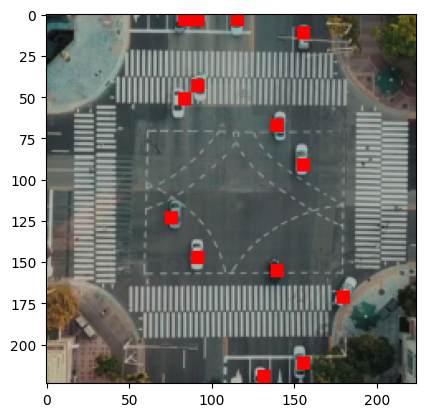

In [77]:
inspect_training_data(data_index=3, mask_index=1)

In [78]:
def fomo_test(data_index: int, mask_index: int, threshold: float):
    val_loader = vehicle_data_module.val_dataloader()
    data = next(iter(val_loader))
    image = data[0][data_index]
    model = FomoModule.load_from_checkpoint(
        "lightning_logs/version_4/checkpoints/epoch=99-step=400.ckpt"
    )
    with torch.no_grad():
        model.eval()
        mask_pred = model(image.unsqueeze(0).cuda())
        mask_pred = mask_pred.cpu()
        mask_pred = postprocess_fomo_mask_prediction(mask_pred, threshold=threshold)
        print(mask_pred.shape)
        display_mask(mask_pred.squeeze(0)[mask_index], image)

torch.Size([1, 2, 28, 28])
There are 6 objects in the picture


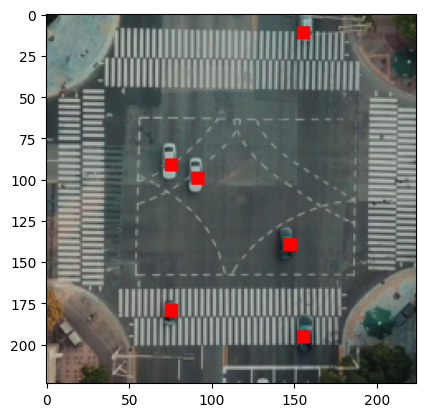

In [82]:
fomo_test(data_index=4, mask_index=1, threshold=0.5)

## FOMO Export

In [80]:
def export_fomo_model():
    model = FomoModule.load_from_checkpoint(
        "lightning_logs/version_4/checkpoints/epoch=99-step=400.ckpt"
    )

    model.to_onnx(
        "fomo.onnx",
        export_params=True,
        input_names=["image"],
        output_names=["masks"],
        input_sample=torch.randn(1, 3, IMAGE_RESOLUTION, IMAGE_RESOLUTION),
    )

In [81]:
export_fomo_model()